Create and train a Proximal Policy Optimization (PPO) model using the provided environment. Train this model for a total_timesteps of 10000. Implement the trading logic to make buy, sell, or hold decisions based on the model's predictions.

Adjust the cash balance and shares_held based on the action taken (buy/sell) and allow the model to trade a certain percentage of its balance each step.
Monitor balance changes and store the history in balance_history for visualization.
If shares are still held at the end, sell them to update the final balance.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from eodhd import APIClient

import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import Actions
from stable_baselines3 import PPO


In [2]:
api_key = os.getenv('EODHD_API_KEY')
api = APIClient(api_key)

In [3]:
def get_ticker_data(ticker):
    data = api.get_eod_historical_stock_market_data(symbol = ticker, period='d', from_date = first_date, to_date = today_date, order='a')
    return pd.DataFrame(data)

In [4]:
# n year trading days
n_years = 16

today = datetime.today().date() 
today_date = today.strftime('%Y-%m-%d')

first = today - timedelta(days= n_years * 365)
first_date = first.strftime('%Y-%m-%d')

today_date, first_date

('2025-04-03', '2009-04-07')

In [5]:
ticker ="AAPL"

data = get_ticker_data(ticker)
data

,date,open,high,low,close,adjusted_close,volume
0,2009-04-07,116.53040000,116.67040000,114.18960000,114.99880000,3.46070000,536580800
1,2009-04-08,115.43000000,116.79080000,114.57880000,116.32040000,3.50050000,455630000
2,2009-04-09,118.42040000,119.99960000,117.96120000,119.57120000,3.59830000,530756800
3,2009-04-13,120.01080000,120.97960000,119.00000000,120.22080000,3.61790000,389236400
4,2009-04-14,119.57120000,120.17040000,117.25000000,118.31120000,3.56040000,454622000
...,...,...,...,...,...,...,...
4018,2025-03-27,221.39000000,224.99000000,220.56000000,223.85000000,223.85000000,37094800
4019,2025-03-28,221.67000000,223.81000000,217.68000000,217.90000000,217.90000000,39818600
4020,2025-03-31,217.01000000,225.62000000,216.23000000,222.13000000,222.13000000,65299300
4021,2025-04-01,219.81000000,223.68000000,218.90000000,223.19000000,223.19000000,36412700


In [6]:
aapl = data[['date', 'adjusted_close']]
aapl['date'] = pd.to_datetime(aapl['date'])
aapl.rename(columns={'adjusted_close': 'Close', 'date': 'Date'}, inplace=True)

aapl['Returns'] = aapl.Close.pct_change() # *3.568 to get the observations values of the observation space (?)

# mean_returns = aapl['Returns'].mean()
# std_returns = aapl['Returns'].std()
# aapl['Normalized_Returns'] = (aapl['Returns'] - mean_returns) / std_returns
# aapl['Log_Returns'] = np.log(aapl['Close'] / aapl['Close'].shift(1))

aapl.set_index('Date', inplace=True)
aapl.head(11)

C:\Users\Alienware\AppData\Local\Temp\ipykernel_15144\1001164542.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aapl['date'] = pd.to_datetime(aapl['date'])
C:\Users\Alienware\AppData\Local\Temp\ipykernel_15144\1001164542.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aapl.rename(columns={'adjusted_close': 'Close', 'date': 'Date'}, inplace=True)
C:\Users\Alienware\AppData\Local\Temp\ipykernel_15144\1001164542.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

,Close,Returns
Date,,
2009-04-07,3.46070000,NaN
2009-04-08,3.50050000,0.01150056
2009-04-09,3.59830000,0.02793887
2009-04-13,3.61790000,0.00544702
2009-04-14,3.56040000,-0.01589320
2009-04-15,3.54020000,-0.00567352
2009-04-16,3.65490000,0.03239930
2009-04-17,3.71420000,0.01622479
2009-04-20,3.62630000,-0.02366593


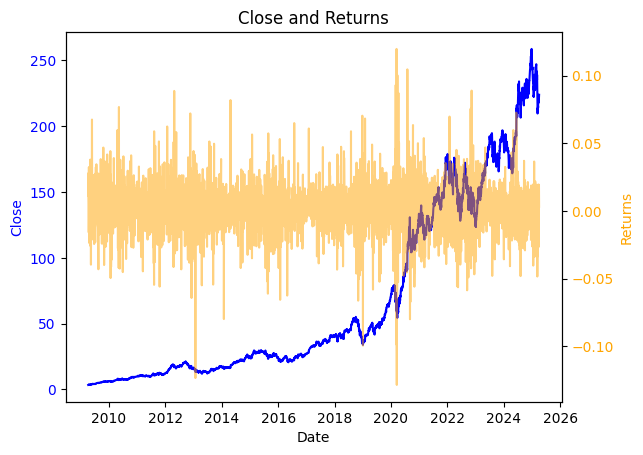

In [7]:
fig, ax1 = plt.subplots()

# Plot 'Close' on the primary y-axis
ax1.plot(aapl.index, aapl['Close'], color='blue', label='Close')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis for 'Returns'
ax2 = ax1.twinx()
ax2.plot(aapl.index, aapl['Returns'], color='orange', label='Returns', alpha=0.5)
ax2.set_ylabel('Returns', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add a title and show the plot
plt.title('Close and Returns')
plt.show()


In [8]:
# n_weeks = 2 # number of weeks to consider in the windows calculation

# # Function to create two-week windows (Monday to Friday trading days)
# def create_two_week_windows(data, n_weeks):
#     windows = []
#     start_date = data.index[0]
#     if start_date.weekday() != 0:  # Ensure the first start_date is a Monday
#         start_date += pd.offsets.Week(weekday=0)
    
#     two_week_offset = pd.offsets.Week(weekday=4, n=n_weeks)  # Two Fridays ahead (2 weeks total)
    
#     while start_date + two_week_offset <= data.index[-1]:  # Use the variable here
#         end_date = start_date + two_week_offset
#         window_data = data.loc[start_date:end_date]
#         if len(window_data) > 0:  # Accept windows with at least one trading day
#             windows.append(window_data)
#         start_date += pd.offsets.Week(weekday=0)  # Move to the next Monday
#     return windows


In [9]:
# # Create two-week windows from the dataset
# two_week_windows = create_two_week_windows(aapl, n_weeks=n_weeks)
# print(len(two_week_windows))
# two_week_windows[0]

In [10]:
# def sliding_window_training(two_week_windows, train_percentage=0.75, ts_mul=3, trade_amount = 100000):
#     # ts_mul : how many times the agent interacts with each trading day (used to define the total_timesteps number)
#     total_windows = len(two_week_windows)
#     train_windows_count = int(total_windows * train_percentage)
    
#     balance = 100000
#     balance_history = [balance]
#     shares_held = 0
#     action_stats = {Actions.Sell: 0, Actions.Buy: 0}
    
#     model = None  # PPO model, initialized dynamically during training

#     # Iterate over the sliding window
#     for i in range(train_windows_count, total_windows):
#         # Define training and testing sets
#         train_data = pd.concat(two_week_windows[:i])  # Use all previous windows up to this point for training
#         train_win_size = len(train_data)
#         test_data = two_week_windows[i]  # Use the next window for testing
#         curr_win_size = len(test_data)
        
#         # Create training environment
#         train_env = gym.make('stocks-v0', df=train_data, window_size=curr_win_size) # frame_bound=(0, len(train_data))
        
#         # Train (or retrain) the model

#         if model is None:
#             model = PPO('MlpPolicy', train_env, verbose=0)  # Initialize the model during the first iteration
#         else:
#             model.set_env(train_env)  # Update the environment with the latest training data
#         model.learn(total_timesteps=ts_mul*train_win_size)  # Retrain model
        
#         # Create testing environment
#         test_env = gym.make('stocks-v0', df=test_data, window_size=curr_win_size) # frame_bound=(0, len(test_data))
        
#         # Test the model on the next window
#         observation, info = test_env.reset # (seed=2024)
#         step = 0
        
#         while True:
#             action, _states = model.predict(observation)
#             current_price = test_env.unwrapped.prices[test_env.unwrapped._current_tick]
            
#             observation, reward, terminated, truncated, info = test_env.step(action)
            
#             trade_amount = trade_amount  
            
#             if action == Actions.Buy.value:
#                 shares_to_buy = trade_amount / current_price
#                 shares_held += shares_to_buy
#                 balance -= trade_amount
#                 print(f"{step}: BUY  {shares_to_buy:.2f} shares at ${current_price:.2f} | Balance: ${balance:.2f}")
#             elif action == Actions.Sell.value and shares_held > 0:
#                 balance += shares_held * current_price
#                 print(f"{step}: SELL {shares_held:.2f} shares at ${current_price:.2f} | Balance: ${balance:.2f}")
#                 shares_held = 0
#             else:
#                 print(f"{step}: HOLD | Current price: ${current_price:.2f} | Balance: ${balance:.2f}")
            
#             action_stats[Actions(action)] += 1
#             balance_history.append(balance)
            
#             step += 1
#             if terminated or truncated:
#                 break
        
#         # Sell any remaining shares at the end of the test window
#         if shares_held > 0:
#             balance += shares_held * current_price
#             print(f"\nFinal SELL {shares_held:.2f} shares at ${current_price:.2f} | Balance: ${balance:.2f}")
#             shares_held = 0

#         test_env.close()
    
#     # Plot balance history
#     plt.plot(balance_history)
#     plt.title('Balance History Over Sliding Windows')
#     plt.xlabel('Steps')
#     plt.ylabel('Balance ($)')
#     plt.show()

#     # Print results
#     print("Action stats:", action_stats)
#     print(f"Final Balance: ${balance:.2f}")


In [11]:
# Set window size (lookback window), start and end index of data

data = aapl
window_size = 10 # last trading days to check
start_index = window_size
# start_index = 10
end_index = len(data)-1

start_index, end_index

(10, 4022)

In [12]:
data.dropna().head(10)

,Close,Returns
Date,,
2009-04-08,3.50050000,0.01150056
2009-04-09,3.59830000,0.02793887
2009-04-13,3.61790000,0.00544702
2009-04-14,3.56040000,-0.01589320
2009-04-15,3.54020000,-0.00567352
2009-04-16,3.65490000,0.03239930
2009-04-17,3.71420000,0.01622479
2009-04-20,3.62630000,-0.02366593
2009-04-21,3.66420000,0.01045142


In [13]:
# Create the environment using the pre-built 'stocks-v0', passing in the data loaded above
# window_size is how far the environment can look back at each step
# frame_bound is the bounding box of the environment, the size of our data
env = gym.make('stocks-v0', df=data, frame_bound=(start_index, end_index), window_size=window_size)
print("Observation Space:", env.observation_space)

Observation Space: Box(-10000000000.0, 10000000000.0, (10, 2), float32)


In [14]:
env.action_space

Discrete(2)

In [15]:
# Initialise cash balance tracking and other variables
balance = 100000
balance_history = [balance]
shares_held = 0
action_stats = {Actions.Sell: 0, Actions.Buy: 0}
observation, info = env.reset() # (seed=2024)

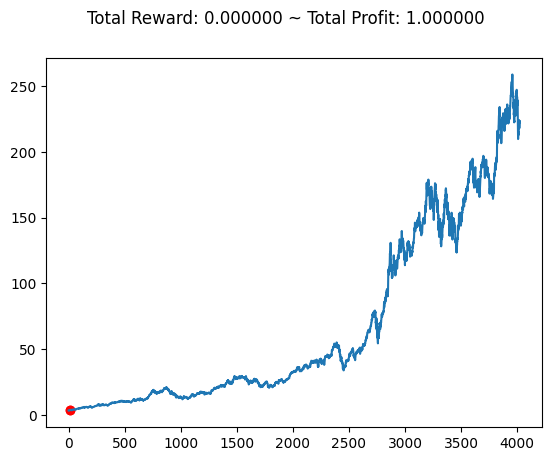

In [16]:
env.render()

In [17]:
print(env.unwrapped._current_tick)
env.unwrapped.prices[env.unwrapped._current_tick]

10


3.6566

In [18]:
print(data.iloc[env.unwrapped._current_tick][0])
data.dropna().iloc[env.unwrapped._current_tick-window_size : env.unwrapped._current_tick] # window_size until current_tick

3.6566


C:\Users\Alienware\AppData\Local\Temp\ipykernel_15144\3405277079.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(data.iloc[env.unwrapped._current_tick][0])


,Close,Returns
Date,,
2009-04-08,3.50050000,0.01150056
2009-04-09,3.59830000,0.02793887
2009-04-13,3.61790000,0.00544702
2009-04-14,3.56040000,-0.01589320
2009-04-15,3.54020000,-0.00567352
2009-04-16,3.65490000,0.03239930
2009-04-17,3.71420000,0.01622479
2009-04-20,3.62630000,-0.02366593
2009-04-21,3.66420000,0.01045142


In [19]:
observation

array([[ 3.5005,  0.0398],
       [ 3.5983,  0.0978],
       [ 3.6179,  0.0196],
       [ 3.5604, -0.0575],
       [ 3.5402, -0.0202],
       [ 3.6549,  0.1147],
       [ 3.7142,  0.0593],
       [ 3.6263, -0.0879],
       [ 3.6642,  0.0379],
       [ 3.6566, -0.0076]], dtype=float32)

In [20]:
info

{'total_reward': 0.0, 'total_profit': 1.0, 'position': <Positions.Short: 0>}

In [21]:
# Train the PPO model
model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=10000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 1508 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.01e+03    |
|    ep_rew_mean          | 123         |
| time/                   |             |
|    fps                  | 988         |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008901206 |
|    clip_fraction        | 0.0265      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.686      |
|    explained_variance   | -0.00135    |
|    learning_rate        | 0.0003      |
|    loss               

In [22]:
iters = 0

np.set_printoptions(suppress=True, precision=4)

while True:

    print('env.unwrapped._current_tick (BEFORE "env.step")', env.unwrapped._current_tick,'\n')
    print('env.unwrapped.prices[env.unwrapped._current_tick] (BEFORE "env.step"):', env.unwrapped.prices[env.unwrapped._current_tick],'\n')
    print('observation (BEFORE "env.step"):','\n', observation,'\n')
    
    print('data.iloc[env.unwrapped._current_tick][0]:', data.iloc[env.unwrapped._current_tick][0],'\n')
    print('data.dropna().iloc[env.unwrapped._current_tick-window_size : env.unwrapped._current_tick]:','\n', 
          data.dropna().iloc[env.unwrapped._current_tick-window_size : env.unwrapped._current_tick].values,'\n') # window_size until current_tick
    
    action, _states = model.predict(observation)
    print('action after prediction over observation:', action,'\n')
    
    observation, reward, terminated, truncated, info = env.step(action)

    print('env.unwrapped._current_tick (AFTER "env.step")', env.unwrapped._current_tick,'\n')
    print('env.unwrapped.prices[env.unwrapped._current_tick] (AFTER "env.step"):', env.unwrapped.prices[env.unwrapped._current_tick],'\n')
    print('observation (AFTER "env.step"):','\n', observation,'\n')

    iters+=1

    print ('\n','-----------------------------------------------------------------------------------------------','\n')

    if iters == 3:
        break



env.unwrapped._current_tick (BEFORE "env.step") 2228 

env.unwrapped.prices[env.unwrapped._current_tick] (BEFORE "env.step"): 38.3916 

observation (BEFORE "env.step"): 
 [[ 3.5005  0.0398]
 [ 3.5983  0.0978]
 [ 3.6179  0.0196]
 [ 3.5604 -0.0575]
 [ 3.5402 -0.0202]
 [ 3.6549  0.1147]
 [ 3.7142  0.0593]
 [ 3.6263 -0.0879]
 [ 3.6642  0.0379]
 [ 3.6566 -0.0076]] 

data.iloc[env.unwrapped._current_tick][0]: 38.3916 

data.dropna().iloc[env.unwrapped._current_tick-window_size : env.unwrapped._current_tick]: 
 [[39.2367 -0.0059]
 [39.3448  0.0028]
 [39.4271  0.0021]
 [37.7163 -0.0434]
 [36.774  -0.025 ]
 [38.3109  0.0418]
 [37.4907 -0.0214]
 [36.4591 -0.0275]
 [36.9051  0.0122]
 [38.3916  0.0403]] 

action after prediction over observation: 1 

env.unwrapped._current_tick (AFTER "env.step") 2229 

env.unwrapped.prices[env.unwrapped._current_tick] (AFTER "env.step"): 38.7762 

observation (AFTER "env.step"): 
 [[39.3448  0.1081]
 [39.4271  0.0823]
 [37.7163 -1.7108]
 [36.774  -0.9423]
 [38.31

C:\Users\Alienware\AppData\Local\Temp\ipykernel_15144\238575643.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('data.iloc[env.unwrapped._current_tick][0]:', data.iloc[env.unwrapped._current_tick][0],'\n')


In [23]:
.

SyntaxError: invalid syntax (1933637684.py, line 1)

In [ ]:


step = 0
while True:
    action, _states = model.predict(observation)
    current_price = env.unwrapped.prices[env.unwrapped._current_tick]
    
    observation, reward, terminated, truncated, info = env.step(action)
    
    trade_amount = balance * 0.10  # Trade with 10% of current balance
    
    if action == Actions.Buy.value:
        shares_to_buy = trade_amount / current_price
        shares_held += shares_to_buy
        balance -= trade_amount
        print(f"{step}: BUY  {shares_to_buy:.2f} shares at ${current_price:.2f} | Balance: ${balance:.2f}")
    elif action == Actions.Sell.value and shares_held > 0:
        balance += shares_held * current_price
        print(f"{step}: SELL {shares_held:.2f} shares at ${current_price:.2f} | Balance: ${balance:.2f}")
        shares_held = 0
    else:
        print(f"{step}: HOLD | Current price: ${current_price:.2f} | Balance: ${balance:.2f}")
    
    action_stats[Actions(action)] += 1
    balance_history.append(balance)
    
    step += 1
    if terminated or truncated:
        break
		
# If we still hold shares at the end, sell them all
if shares_held > 0:
    balance += shares_held * current_price
    print(f"\nFinal SELL {shares_held:.2f} shares at ${current_price:.2f} | Balance: ${balance:.2f}")
    shares_held = 0

env.close()

print("Action stats:", action_stats)
print(f"Final Balance: ${balance:.2f}")

# Create a price chart showing buy/sell actions
fig, ax = plt.subplots()
env.unwrapped.render_all()
ax.set_title("PPO Agent - Trading Actions")
plt.show()

# Create a chart showing cash balance over time
fig2, ax2 = plt.subplots()
ax2.plot(balance_history)
ax2.set_title("PPO Agent - Balance over time")
ax2.set_xlabel("Steps")
ax2.set_ylabel("Balance ($)")

fig2.tight_layout()
plt.show()

"""
Questions/Answers
- What do you think about the performance of this model?
The model has technically been profitable in that the cash balance is higher than what it started with. However, it is very hard to not be profitable given the extreme increase in the price of AAPL over the 15 years of data provided. You would have made significantly more by simply spending all of the initial balance on shares at the starting date, holding the shares, and selling at the ending date. You likely would have made significantly more over that time period by investing your initial balance in any number of asset classes.
- Why do you think it has performed the way it has?
Every transaction that this model makes is the same size. That is why your balance history will have a lot of spikes and drops, as the model buys with 10% of its balance and then sells again instantly with 10% of its balance, making either a small profit or loss. An improvement that could be made here is calculating the position size based on the confidence the model has in its decision, taking a smaller position if less confident and a larger position if more confident. This model also does not account for any transaction costs or slippage which would be a key factor in a real trading scenario.
- How could the data we have selected impact the performance of the model?
This model uses 15 years of data which is a long time. It is very hard to not make money given a stock that has gone from around $4 to over $200! An interesting experiment would be to select some stock data for a company that has not seen the same extreme growth that Apple has seen and observe how the model performs.
"""
